In [1]:
%matplotlib inline

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

from energy_markets import EnergyMarket
from energy_sectors import NonRenewableEnergySector, RenewableEnergySector


## Renewable energy sector

\begin{align}
    SAK^{\alpha} - RK \\
    SA\alpha K^{\alpha - 1} - R = 0  \\
    A\alpha K^{\alpha - 1} = \frac{R}{S} \\
    K^{\alpha - 1} = \frac{R}{S} \frac{1}{A\alpha} \\
    K = \bigg(\frac{R}{S} \frac{1}{A\alpha}\bigg)^{\alpha - 1} = \bigg(\frac{S}{R} A\alpha\bigg)^{1 - \alpha}
\end{align}

## Non-renewable energy sector

Objective of the non-renewable energy sector is to maximize lifetime profits...

$$ V^{NRE}_0 = \sum_{t=0}^{\infty} \frac{1}{R}\Pi^{NRE}_t $$

where rofits in period $t$...

$$ \Pi^{NRE}_t = P^{E}_tE^{NRE}_t - P^{F}_t F_t - I_t - \Phi\bigg(\frac{I_t}{K^{NRE}_t}\bigg)K^{NRE}_t $$

...where the stock of physical capital used by non-renewable energy sector evolves according to...

$$ K^{NRE}_{t+1} = I_t + (1 - \delta)K^{NRE}_t $$

...and the per-unit investment adjustment costs are captured by the function $\Phi$.  Assume that $\Phi' > 0$ and the $\Phi'' > 0$ (i.e., that $\Phi$ is a convex function).

### Solution
Forming the Lagrangian...

$$ \mathcal{L} \equiv \sum_{t=0}^{\infty} \frac{1}{R}\Pi^{NRE}_t + q_t\bigg[I_t + (1 - \delta)K^{NRE}_t - K^{NRE}_{t+1}\bigg] $$

...choice variables are $F_t$, $I_t$. First-order conditions are...

\begin{align}
   \frac{\partial \mathcal{L}}{\partial F_t} = 0 \equiv 0 =& \psi_t(1-\beta) K^{NRE\ \beta}_t F^{-\beta}_t - P^F_t \\
   \frac{\partial \mathcal{L}}{\partial I_t} = 0 \equiv 0 =& q_t - 1 - \Phi'\bigg(\frac{I_t}{K^{NRE}_t}\bigg) \\
\end{align}


\begin{align}
    P(1 - \beta)\psi K^{\beta}F^{-\beta} = P^F\\
    P(1 - \beta)\psi K^{\beta} = P^FF^{\beta}\\
\end{align}

## Market for energy

## Model parameters

In [3]:
consumer_params = {'energy_quantity': 100}
renewable_params = {'alpha': 0.3, 'tfp': 3.692, 'gross_interest_rate': 1.09}
non_renewable_params = {'beta': 0.67, 'tfp': 1, 'gross_interest_rate': 1.09, 'fossil_fuel_price': 1, 'phi': 0.2, 'eta': 0.9}

In [34]:
def non_renewable_capital_dynamics(capital, previous_capital, consumer_params, non_renewable_params, renewable_params):
    """Second order difference equation describes the dynamics of capital stock."""
    price = EnergyMarket.find_market_price(capital, consumer_params, non_renewable_params, renewable_params)
    fossil_fuel = NonRenewableEnergySector.fossil_fuel_demand(capital, price, non_renewable_params)
    future_capital = NonRenewableEnergySector.future_capital_demand(capital, previous_capital, fossil_fuel, price, non_renewable_params)
    return future_capital


def non_renewable_nvmp_capital(capital, previous_capital, consumer_params, non_renewable_params, renewable_params):
    """Second order difference equation describes the dynamics of capital stock."""
    price = EnergyMarket.find_market_price(capital, consumer_params, non_renewable_params, renewable_params)
    fossil_fuel = NonRenewableEnergySector.fossil_fuel_demand(capital, price, non_renewable_params)
    return NonRenewableEnergySector.net_value_marginal_product_capital(capital, previous_capital, fossil_fuel, price, non_renewable_params)


In [5]:
non_renewable_capital_dynamics(10.0, 5.0, consumer_params, non_renewable_params, renewable_params)

8228.24546114594

In [6]:
def simulate_non_renewable_capital_dynamics(initial_capital, T, consumer_params, non_renewable_params, renewable_params):
    capital = np.empty(T)
    capital[0:2] = initial_capital
    
    for t in range(2, T):
        capital[t] = non_renewable_capital_dynamics(capital[t-1], capital[t-2], consumer_params, non_renewable_params, renewable_params)
    
    return capital

In [28]:
out = simulate_non_renewable_capital_dynamics(np.array([117.476, 117.476,]), 80, consumer_params, non_renewable_params, renewable_params)

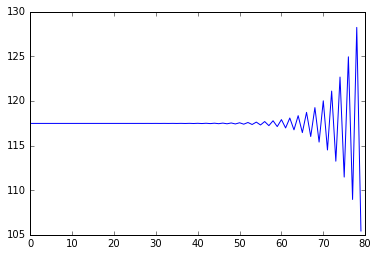

In [29]:
plt.plot(out)

In [15]:
def equilibrium_energy_price(beta, gross_interest_rate, fossil_fuel_price, tfp, **params):
    return (1 / tfp) * (gross_interest_rate**beta * fossil_fuel_price**(1 - beta)) / (beta**beta * (1 - beta)**(1 - beta))

In [16]:
equilibrium_energy_price(**non_renewable_params)

1.9975425342898483

In [18]:
obj = lambda capital: non_renewable_capital_dynamics(capital, capital, consumer_params, non_renewable_params, renewable_params) - capital

In [19]:
obj(1)

4585434.254495223

In [20]:
optimize.brentq(obj, 1, 1000)

117.47630161391399

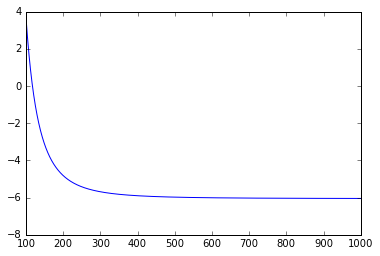

In [30]:
xs = np.logspace(2, 3, 1000)
plt.plot(xs, [obj(x) for x in xs])

In [31]:
nvpm_capital = lambda capital: non_renewable_nvmp_capital(capital, capital, consumer_params, non_renewable_params, renewable_params)

In [32]:
xs = np.logspace(1, 4, 1000)
plt.plot(xs, [nvpm_capital(x) for x in xs])
plt.xscale('log')

TypeError: net_value_marginal_product_capital() got an unexpected keyword argument 'eta'

In [33]:
[nvpm_capital(x) for x in xs]

TypeError: net_value_marginal_product_capital() got an unexpected keyword argument 'eta'